In [90]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader

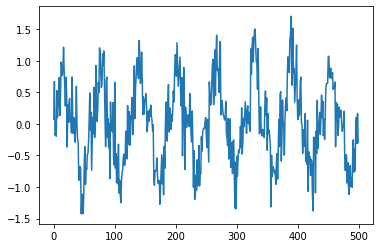

In [85]:
# Generate data
t = np.linspace(0, 50, 500)
signal = np.sin(t)**3 + np.random.normal(0, 0.3, 500)

plt.plot(signal)

In [105]:
class GenericDataset(Dataset):

    def __init__(self, X, lags, forecast_horizon):
        self.X = copy.deepcopy(X)
        self.lags = lags
        self.forecast_horizon = forecast_horizon

    def __len__(self):
        
        length = len(self.X)-50
        return length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = np.array(self.X[idx:idx+self.lags]).reshape(self.lags,1)
        y = np.array(self.X[idx+self.lags:idx+self.lags+self.forecast_horizon]).reshape(-1, self.forecast_horizon)

        return x, y

In [129]:
BATCH_SIZE = 1

torch_dataset = GenericDataset(signal, 5, 1)

train_loader = DataLoader(dataset=torch_dataset, 
                            batch_size=BATCH_SIZE, 
                            shuffle=True, num_workers=0)

In [171]:
class NaiveCustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # i_t
        self.U_i = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.V_i = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.Tensor(hidden_size))
        
        # f_t
        self.U_f = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.V_f = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.Tensor(hidden_size))
        
        # c_t
        self.U_c = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.V_c = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_c = nn.Parameter(torch.Tensor(hidden_size))
        
        # o_t
        self.U_o = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.V_o = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.Tensor(hidden_size))
        
        self.init_weights()
        
    def init_weights(self):
        
        std_dv = 1.0/np.sqrt(self.hidden_size)
        
        for weight in self.parameters():
            weight.data.uniform_(-std_dv, std_dv).double()
            
        return
    
    def forward(self, x, init_states=None):
        
        """Assumes x is shaped (batch_size, sequence_length, num_features).
        """
        
        batch_size, sequence_length, _ = x.size()
        hidden_seq = []
        
        if init_states is None:
            h_t, c_t = (torch.zeros(batch_size, self.hidden_size).to(x.device).double(),
                       torch.zeros(batch_size, self.hidden_size).to(x.device).double())
        else:
            h_t, c_t = init_states
            
        for t in range(sequence_length):
            x_t = x[:,t,:]
            
            i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
            f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
            g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
            o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            
            hidden_seq.append(h_t.unsqueeze(0))
            
        # reshape hidden sequence and return array
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0,1).contiguous()
        return hidden_seq, h_t, c_t

In [172]:
N_HIDDEN = 64

net = NaiveCustomLSTM(1, N_HIDDEN)
net = net.double()

optimizer = torch.optim.Adam(net.parameters(),lr=0.0001)
criterion = nn.MSELoss()

In [173]:
NUM_EPOCHS = 25

for epoch in range(NUM_EPOCHS):
    for inputs, targets in train_loader:

        # Forward pass
        inputs = inputs.double()
        targets = targets.double()
        _, outputs, _ = net.forward(inputs)
        loss = criterion(outputs, targets)
    
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss.item()))

Epoch [1/25], Loss: 0.4009
Epoch [2/25], Loss: 0.3498
Epoch [3/25], Loss: 0.2603
Epoch [4/25], Loss: 0.2031
Epoch [5/25], Loss: 0.2964
Epoch [6/25], Loss: 0.1263
Epoch [7/25], Loss: 0.1275
Epoch [8/25], Loss: 0.0114
Epoch [9/25], Loss: 0.0831
Epoch [10/25], Loss: 0.1635
Epoch [11/25], Loss: 0.0266
Epoch [12/25], Loss: 0.3746
Epoch [13/25], Loss: 0.1486
Epoch [14/25], Loss: 0.0055
Epoch [15/25], Loss: 0.2853
Epoch [16/25], Loss: 0.0708
Epoch [17/25], Loss: 0.0217
Epoch [18/25], Loss: 0.1365
Epoch [19/25], Loss: 0.1069
Epoch [20/25], Loss: 1.1347
Epoch [21/25], Loss: 0.0490
Epoch [22/25], Loss: 0.0175
Epoch [23/25], Loss: 0.0106
Epoch [24/25], Loss: 0.0248
Epoch [25/25], Loss: 0.0480
